In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import torch
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tqdm
import torch.nn as nn
from torch.utils.data import Dataset
from collections import namedtuple
import tqdm
from torchvision.transforms import Resize, Compose, ToPILImage, ToTensor
from PIL import Image
import torch.nn.functional as F
from conv_lstm import ConvLSTM


In [2]:
training_videos_path = Path('Avenue Dataset') / 'training_vol'

In [3]:
training_videos_path / 'vol01.mat'

WindowsPath('Avenue Dataset/training_vol/vol01.mat')

In [4]:
videodata = sio.loadmat(str(training_videos_path / 'vol01.mat'))  

In [5]:
video1 = videodata['vol']


In [6]:
video1.shape

(120, 160, 1364)

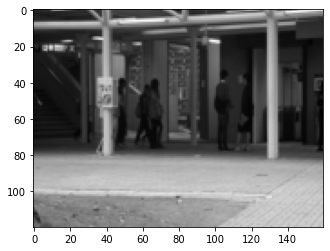

In [7]:
plt.imshow(video1[..., 0], cmap = 'gray')

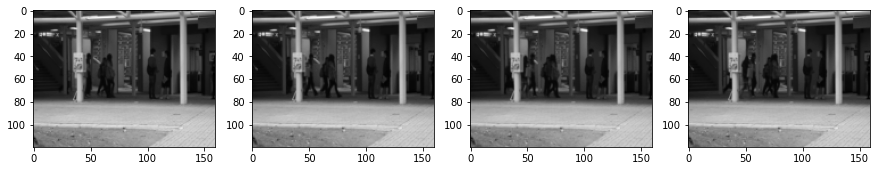

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.imshow(video1[..., 0], cmap = 'gray')
plt.subplot(1,4,2)
plt.imshow(video1[..., 4], cmap = 'gray')
plt.subplot(1,4,3)
plt.imshow(video1[..., 8], cmap = 'gray')
plt.subplot(1,4,4)
plt.imshow(video1[..., 12], cmap = 'gray')


In [9]:
transform = Compose([ToPILImage(),Resize((227,227)), ToTensor()]) 

def generate_stride_set(video_array, stride_size = 1, window_length = 10):

    end = video_array.shape[-1] - window_length
    windows = []
    for i in tqdm.tqdm(range(0, end, stride_size)):
        x = video_array[..., i:i+window_length]
        transformed_x = []
        for j in range(x.shape[-1]):
            temp = x[..., j]
            temp_transformed = transform(temp)
            transformed_x.append(temp_transformed)
        x = torch.cat(transformed_x)
        windows.append(torch.unsqueeze(x,0))
        # shape  = (10,227,227) 
    
    windows = torch.cat(windows)
    return windows
    



In [10]:
stride_3_set = generate_stride_set(video1, stride_size=3)
stride_1_set = generate_stride_set(video1)
stride_2_set = generate_stride_set(video1, stride_size=2)


100%|██████████| 677/677 [00:04<00:00, 161.50it/s]


In [11]:
stride_3_set.shape

torch.Size([452, 10, 227, 227])

In [12]:
data_set = torch.unsqueeze(torch.cat([stride_1_set, stride_2_set, stride_3_set]),1)
data_set.shape

torch.Size([2483, 1, 10, 227, 227])

In [13]:
class SpatialEncoder(nn.Module):

    def __init__(self):
        super(SpatialEncoder, self).__init__()
        self.conv1 = nn.Conv3d(in_channels = 1, out_channels= 128, kernel_size= (1,11,11), stride=(1,4,4))
        self.conv2 = nn.Conv3d(in_channels= 128, out_channels= 64, kernel_size= (1,5,5), stride=(1,2,2))
        self.convlstm = ConvLSTM(input_dim=64,
                 hidden_dim=[64,32,64],
                 kernel_size=(3, 3),
                 num_layers=3,
                 batch_first=True,
                 bias=True,
                 return_all_layers=True)
        self.convt1 = nn.ConvTranspose3d(64, 128,(1,5,5), stride=(1,2,2))
        self.convt2 = nn.ConvTranspose3d(128, 1,(1,11,11), stride=(1,4,4))
    def forward(self, X):

        X = self.conv1(X)
        X = F.tanh(X)
        X = self.conv2(X)
        X = F.tanh(X)
        # batch, channels, time, h, w
        assert X.size()[1:] == torch.Size([64, 10, 26, 26])
        # batch, time, channels, h, w
        X = X.permute([0, 2, 1, 3, 4])
        layer_output_list, last_state_list = self.convlstm(X)
        X = layer_output_list[-1]
        # batch, depth, channels, h, w
        assert X.shape[1:] == torch.Size([10,64,26,26])
        # batch, channels, depth, h, w
        X = X.permute([0, 2, 1, 3, 4])
        X = self.convt1(X)
        X = F.tanh(X)
        X = self.convt2(X)
        X = F.tanh(X)
        assert X.shape[1:] == torch.Size([1, 10,227,227])
        return X


In [14]:
class AnomalyDataset(Dataset):
    
    def __init__(self, X, train=True, fraction = 0.8):

        pivot = int(fraction * len(X))
        if train:
            self.X = X[:pivot]
        else:
            self.X = X[pivot:]

    def __len__(self):

        return len(self.X)
    
    def __getitem__(self, ndx):
        return self.X[ndx, ...]




In [15]:
##### TRENOWANIE ######

In [16]:
transfms = Compose([ToPILImage(),Resize((227,227)), ToTensor()]) 

In [17]:
device = torch.device('cuda')
model = SpatialEncoder()
model = model.to(device)


In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss = nn.MSELoss()
epochs = 10

set_train = AnomalyDataset(data_set, train=True) 
set_test = AnomalyDataset(data_set, train=False)

train_loader = torch.utils.data.DataLoader(set_train, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(set_test, batch_size=8, shuffle=True)


In [19]:
losses_train = []
losses_test = []

In [20]:
for i in tqdm.tqdm(range(epochs)):

  print('train')
  batch_loss_train = []
  model.train()
  for X_batch in tqdm.tqdm(train_loader):
    optimizer.zero_grad()
    X_batch = X_batch.to(device)
    predictions = model(X_batch)
    loss_val = loss(predictions, X_batch)
    batch_loss_train.append(loss_val.item())
    loss_val.backward()
    optimizer.step()
  losses_train.append(np.mean(batch_loss_train))

  print('test')

  model.eval()
  batch_loss_test = []
  for X_batch in tqdm.tqdm(test_loader):
    X_batch = X_batch.to(device)
    predictions = model(X_batch)
    loss_val = loss(predictions, X_batch)
    batch_loss_test.append(loss_val.item())
  losses_test.append(np.mean(batch_loss_test))

01:16<00:28,  2.32it/s]
100%|██████████| 249/249 [01:44<00:00,  2.37it/s]

  3%|▎         | 2/63 [00:00<00:03, 19.80it/s]test

  0%|          | 0/249 [00:00<?, ?it/s]train

100%|██████████| 249/249 [01:44<00:00,  2.38it/s]

  3%|▎         | 2/63 [00:00<00:03, 19.42it/s]test

100%|██████████| 10/10 [18:06<00:00, 108.63s/it]


In [21]:
x = next(iter(train_loader))

In [22]:
x.shape

torch.Size([8, 1, 10, 227, 227])

In [23]:
torch.mean(model(x.to(device)))

tensor(0.3996, device='cuda:0', grad_fn=<MeanBackward0>)

In [24]:
import matplotlib.pyplot as plt

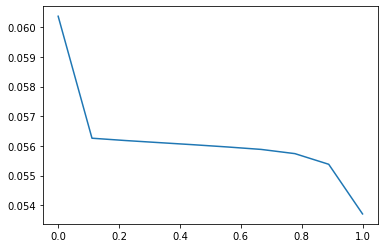

In [25]:
plt.plot(np.linspace(0,1,len(losses_train)), losses_train)

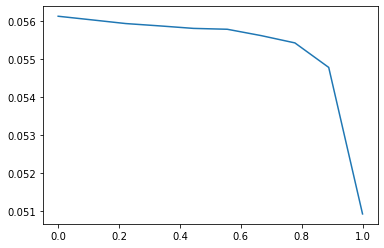

In [26]:
plt.plot(np.linspace(0,1,len(losses_train)), losses_test)

In [34]:
x[:1,...].shape
out = model(x[:1,...].to(device))

C:\Users\cdami\Anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [45]:
input = x[:1,...]
input = input.squeeze()
one_frame = input[0,...]
one_frame_numpy = one_frame.numpy()

In [66]:
out = out.to(torch.device('cpu'))

In [68]:
out = out.squeeze()[0,...].squeeze().detach().numpy()

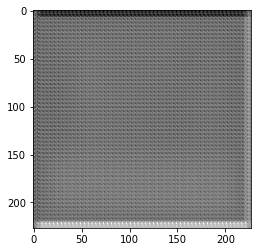

In [71]:
plt.imshow(out, cmap='gray')

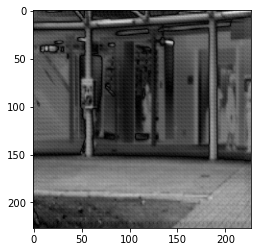

In [77]:
plt.imshow(abs(one_frame_numpy - out), cmap='gray')

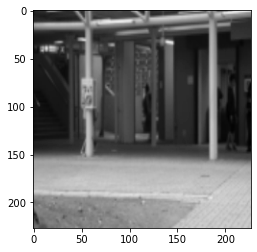

In [79]:
plt.imshow(one_frame_numpy, cmap='gray')

In [75]:
out

array([[0.3522413 , 0.38904363, 0.34348857, ..., 0.38682288, 0.35486943,
        0.37315357],
       [0.38596186, 0.34713244, 0.36500925, ..., 0.36903602, 0.36629695,
        0.36769676],
       [0.36527225, 0.36244228, 0.37416214, ..., 0.38504857, 0.35048   ,
        0.36005333],
       ...,
       [0.38346368, 0.3786592 , 0.39522642, ..., 0.39033234, 0.4133402 ,
        0.40819752],
       [0.38820782, 0.37894338, 0.38639453, ..., 0.4127627 , 0.40221614,
        0.40038544],
       [0.38586843, 0.37673783, 0.38482684, ..., 0.39923576, 0.38687044,
        0.41745862]], dtype=float32)